# <span style="color:blue">Developing, Training, and Deploying a TensorFlow model on Google Cloud Platform</span> 

**Import Libraries**

In [134]:
import pandas as pd
from io import BytesIO
import datetime
from datetime import timedelta

import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
sns.set()

In [132]:
!pip3 install datalab

## 1. Setting up Cloud Environment on your GCP Project 

**Change to your bucket and project name, to set up environment in your project, store files in your bucket and to run the model on cloud ml engine**

In [72]:
BUCKET='usc_demo'
PROJECT='gcp-de-exp'
REGION='us-central1'

In [73]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

## 2. Data Preprocessing

**Select the data file, date and the target variables that you want to use for the revenue forecast**

In [74]:
data_file='data.csv'
date='date_of_sale'
target='net_sales'

In [75]:
data = pd.read_csv("data.csv", parse_dates=[date])

In [76]:
data = data[data.upc == 25097000000]
data.head()

,Unnamed: 0,upc,date_of_sale,store_id,departmentname,categoryname,net_sales,count
0,0,25097000000,2017-11-22,2,Bakery,Viktor Benes/ Renaud Bakery,12.28,790168
1,1,25097000000,2017-01-30,2,Bakery,Viktor Benes/ Renaud Bakery,9.50,790168
2,2,25097000000,2016-04-11,2,Bakery,Viktor Benes/ Renaud Bakery,2.75,790168
3,3,25097000000,2017-07-02,2,Bakery,Viktor Benes/ Renaud Bakery,8.77,790168
4,4,25097000000,2018-05-07,2,Bakery,Viktor Benes/ Renaud Bakery,11.45,790168


In [77]:
upc_code = data.upc[0]
departmentname = data.departmentname[0]
print(upc_code,departmentname)

25097000000 Bakery


In [78]:
data = data[[date, target]]

In [79]:
data = data.set_index(data[date])

In [80]:
data = data.drop(columns = [date])

In [81]:
data = data["net_sales"].resample("D").sum()

In [82]:
data = data.to_frame()

In [83]:
data.head()

,net_sales
date_of_sale,
2016-01-03,8223.23
2016-01-04,7021.80
2016-01-05,6610.42
2016-01-06,6445.34
2016-01-07,7195.91


In [84]:
def data_prep(data):
    data_np = data.values
    train = []
    for i in range(90, len(data_np)):
        train.append(data_np[i-90:i])
        
    list_zero = train[0]
    df = pd.DataFrame(list_zero).T
    
    for i in range(1, len(train)):
        a = train[i]
        b = pd.DataFrame(a).T
        b.index = [i]
        df = pd.concat((df, b), axis = 0)
        
    ind = int(0.8*len(df))
    train = df[:ind]
    eval_ = df[ind:]
    test = eval_.iloc[-1]
    test = test[30:]
    
    
    last_date = data[-30:-29]
    last_date = last_date.index
    
    dates = []
    for i in range(0, 60):
        temp = last_date + timedelta(days = 1)
        dates.append(last_date)
        last_date = temp
    dates = pd.DataFrame(dates)
    
    return train, eval_, test, dates

In [85]:
train, eval_, test, dates = data_prep(data)

In [86]:
test = test.tolist()

In [87]:
train.to_csv("train.csv", index = False, header = False)
eval_.to_csv("eval.csv", index = False, header = False)

In [88]:
%%bash
gsutil cp -r  ./cnnmodel gs://$BUCKET/cnnmodel

Copying file://./cnnmodel/sourcecode_supply_ml_churnpred_solution.ipynb [Content-Type=application/octet-stream]...
Copying file://./cnnmodel/trainer/task.py [Content-Type=text/x-python]...
Copying file://./cnnmodel/trainer/model.py [Content-Type=text/x-python]...
|
Operation completed over 3 objects/88.8 KiB.                                     


In [89]:
%%bash
gsutil cp -r  ./train.csv gs://$BUCKET/data
gsutil cp -r  ./eval.csv gs://$BUCKET/data

Copying file://./train.csv [Content-Type=text/csv]...
\
Operation completed over 1 objects/946.8 KiB.                                    
Copying file://./eval.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/268.4 KiB.                                    


## 3. Train in Cloud ML 

In [97]:
%%bash
SEQ_LEN=90
OUTDIR="gs://${BUCKET}/out/trained"
JOBNAME=revenueml_$(date -u +%y%m%d_%H%M%S)
REGION=us-central1
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=${PWD}/cnnmodel/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket="gs://${BUCKET}/" \
  --scale-tier=BASIC \
  --runtime-version=1.8 \
  -- \
  --train_data_paths="gs://${BUCKET}/data/train.csv" \
  --eval_data_paths="gs://${BUCKET}/data/eval.csv"  \
  --output_dir=$OUTDIR \
  --train_steps=2000 \
  --sequence_length=$SEQ_LEN \
  --kernel_size=15 \
  --learning_rate=0.0047 \
  --train_batch_size=326

jobId: revenueml_190711_113445
state: QUEUED


Removing gs://usc_demo/out/trained/#1562841161040699...
Removing gs://usc_demo/out/trained/checkpoint#1562841163111736...
Removing gs://usc_demo/out/trained/eval/events.out.tfevents.1562840391.cmle-training-11374821800598740212#1562840887784540...
Removing gs://usc_demo/out/trained/eval/#1562840391786059...
Removing gs://usc_demo/out/trained/events.out.tfevents.1562840381.cmle-training-1062624048431042912#1562841165046832...
Removing gs://usc_demo/out/trained/export/Servo/1562840392/variables/#1562840400638826...
Removing gs://usc_demo/out/trained/eval/events.out.tfevents.1562840391.cmle-training-1062624048431042912#1562841166843300...
Removing gs://usc_demo/out/trained/export/#1562840393753938...
Removing gs://usc_demo/out/trained/export/Servo/#1562840394325766...
Removing gs://usc_demo/out/trained/export/Servo/1562840392/saved_model.pb#1562840400342261...
Removing gs://usc_demo/out/trained/events.out.tfevents.1562840380.cmle-training-11374821800598740212#1562840879099640...
Removing 

## 4. Create and Delploy the trained job on model 

In [98]:
%%bash
REGION='us-central1'
MODEL_NAME=revenueml_$(date -u +%y%m%d_%H%M%S)
MODEL_VERSION="v1"
gcloud ml-engine models create $MODEL_NAME
echo $MODEL_NAME > a.txt
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/out/trained/export/Servo/ | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"

gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version 1.8

Deleting and deploying revenueml_190711_115941 v1 from gs://usc_demo/out/trained/export/Servo/1562845820/ ... this will take a few minutes


Created ml engine model [projects/gcp-de-exp/models/revenueml_190711_115941].
Creating version (this might take a few minutes)......
...............................................................................................................................................................................................................................................................................................done.


## Cloud ML Prediction

In [139]:
%%bash
export GOOGLE_APPLICATION_CREDENTIALS="gcp-de-exp-82216ef33d56.json"

In [140]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

f = open("a.txt","r")
MODEL_NAME = f.read().replace('\n', '')
print(MODEL_NAME)

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials)

test = test
request_data = {"instances": [test]}

 
parent = 'projects/%s/models/%s/versions/%s' % (PROJECT,MODEL_NAME, 'v1')
response = api.projects().predict(body = request_data, name = parent).execute()
#print "response={0}".format(response)

W0711 19:21:22.820207 4634899904 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFil

revenueml_190711_115941


In [141]:
a = response["predictions"] 

In [142]:
dictlist=[] 

In [143]:
for key, value in a[0].items():
   temp = [key,value]
   dictlist.append(temp)

In [144]:
predicted = data[-30:]
predicted = pd.DataFrame(predicted)
predicted.reset_index(drop=True, inplace=True)

In [145]:
a = dictlist[0]
a = a[1]
a = pd.DataFrame(a)

In [146]:
frames = (date,predicted,a)
result = pd.concat((dates,predicted,a), axis = 1)
result.columns = ["DATE", "ACTUAL","FORECAST"]
forecast_df = result
forecast_df = forecast_df.round()
forecast_df = forecast_df.fillna(0)
for i in range(0, len(forecast_df)):
    if forecast_df.FORECAST[i] <= 0:
        forecast_df.FORECAST[i] = 0
forecast_df

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,DATE,ACTUAL,FORECAST
0,2018-08-02,7985.0,9471.0
1,2018-08-03,11410.0,7449.0
2,2018-08-04,22748.0,13126.0
3,2018-08-05,17623.0,20787.0
4,2018-08-06,14273.0,18351.0
5,2018-08-07,13994.0,9537.0
6,2018-08-08,15609.0,7393.0
7,2018-08-09,25143.0,14213.0
8,2018-08-10,34158.0,19768.0
9,2018-08-11,34716.0,30585.0


In [147]:
upc_list = []
departmentname_list = []

for i in range(0, 60):
    upc_list.append(upc_code)
    departmentname_list.append(departmentname)
    
details_df = pd.DataFrame({
    "upc_code": upc_list,
    "departmentname": departmentname_list
})

final_df = pd.concat((details_df, forecast_df), axis = 1)
final_df

,upc_code,departmentname,DATE,ACTUAL,FORECAST
0,25097000000,Bakery,2018-08-02,7985.0,9471.0
1,25097000000,Bakery,2018-08-03,11410.0,7449.0
2,25097000000,Bakery,2018-08-04,22748.0,13126.0
3,25097000000,Bakery,2018-08-05,17623.0,20787.0
4,25097000000,Bakery,2018-08-06,14273.0,18351.0
5,25097000000,Bakery,2018-08-07,13994.0,9537.0
6,25097000000,Bakery,2018-08-08,15609.0,7393.0
7,25097000000,Bakery,2018-08-09,25143.0,14213.0
8,25097000000,Bakery,2018-08-10,34158.0,19768.0
9,25097000000,Bakery,2018-08-11,34716.0,30585.0


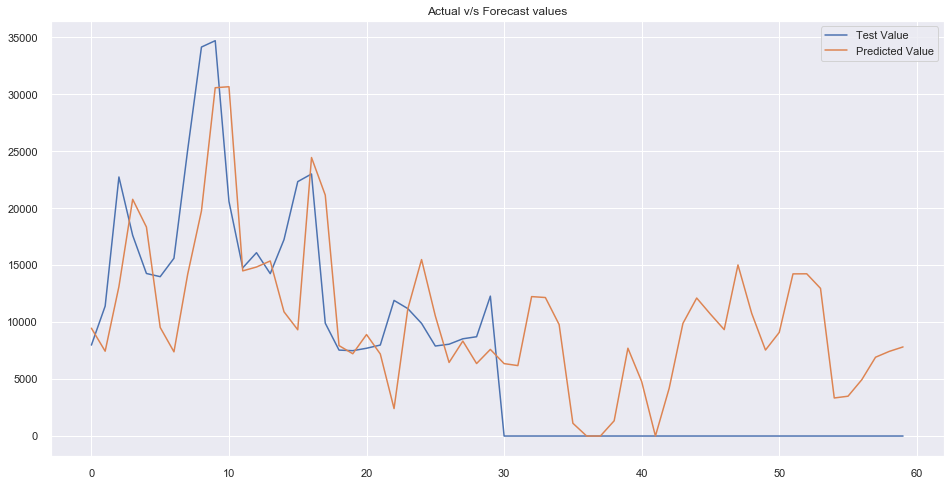

In [148]:
plt.figure(figsize=(16,8))
plt.plot(final_df.ACTUAL, label = "Test Value")
plt.plot(final_df.FORECAST, label = "Predicted Value")
plt.title("Actual v/s Forecast values")
plt.legend()
plt.show()

## Save forecast file to storage bucket

In [155]:
final_df.to_csv("forecast.csv")

In [156]:
final_df.head()

,upc_code,departmentname,DATE,ACTUAL,FORECAST
0,25097000000,Bakery,2018-08-02,7985.0,9471.0
1,25097000000,Bakery,2018-08-03,11410.0,7449.0
2,25097000000,Bakery,2018-08-04,22748.0,13126.0
3,25097000000,Bakery,2018-08-05,17623.0,20787.0
4,25097000000,Bakery,2018-08-06,14273.0,18351.0


In [157]:
!gsutil cp -r forecast.csv gs://gcp-de-exp/usc_demo

Copying file://forecast.csv [Content-Type=text/csv]...
- [1 files][  2.7 KiB/  2.7 KiB]                                                
Operation completed over 1 objects/2.7 KiB.                                      
